In [9]:
from panel_segmentation import utils
import glob
import matplotlib.pyplot as plt
from PIL import Image
import os
import pandas as pd
import folium
import torch
from mmengine import Config
from mmdet.apis import init_detector, inference_detector
from mmdet.registry import VISUALIZERS
import mmcv
import numpy as np
import geopandas
from shapely.ops import unary_union
from shapely.geometry import Polygon, mapping
import shapely

# Automatically Geotag a Fixed Tilt Utility PV Site

The following example uses Panel-Segmentation's automated geotagging pipeline to isolate all the trackers rows and inverters on a utility PV site. This data is then aggregated to create master geoJSON file for the site. The PV site used in this example is available from the American-Made Solar Data Bounty Prize (https://www.energy.gov/eere/solar/american-made-solar-data-bounty-prize). Site metadata and performance data is available via the Open Energy Data Initiative (OEDI), under system ID 2107 (https://data.openei.org/submissions/4568).

In [10]:
sys_latitude, sys_longitude = 38.996306,-122.134111
# Set northwest and southeast bounding lat-longitude coordinates to 
# take all of the satellite images of the site
northwest_lat, northwest_lon =  38.996894,-122.135470
southeast_lat, southeast_lon =   38.995341, -122.134101
google_maps_api_key = "YOUR_API_KEY_HERE"
zoom_level = 20
file_save_folder = "../../../panel_segmentation/examples/automated-geotagging_data_examples_fixed_tilt"
grid_info_list = utils.generateSatelliteImageryGrid(northwest_lat, northwest_lon,
                                                    southeast_lat, southeast_lon,
                                                    google_maps_api_key,
                                                    file_save_folder,
                                                    zoom_level,
                                                    lat_lon_distance=.00067)

C:\Users\kperry\.conda\envs\deep-learning\Lib\site-packages\urllib3\connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maps.googleapis.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
C:\Users\kperry\AppData\Roaming\Python\Python311\site-packages\panel_segmentation\utils.py:240: ResourceWarning: unclosed file <_io.BufferedReader name='../../../panel_segmentation/examples/automated-geotagging_data_examples_fixed_tilt\\38.996894_-122.13547.png'>
  generateSatelliteImage(lat, lon,
C:\Users\kperry\AppData\Roaming\Python\Python311\site-packages\panel_segmentation\utils.py:240: ResourceWarning: unclosed file <_io.BufferedReader name='../../../panel_segmentation/examples/automated-geotagging_data_examples_fixed_tilt\\38.996224_-122.13547.png'>
  generateSatelliteImage(lat, lon,
C:\Users\kperry\AppData\Roaming\Python\Python311\site-packages\pane

Visualize the data set in grid format.

38.996894_-122.13547.png
38.996224_-122.13547.png
38.995554_-122.13547.png
38.994884_-122.13547.png
38.996894_-122.1348.png
38.996224_-122.1348.png
38.995554_-122.1348.png
38.994884_-122.1348.png
38.996894_-122.13413.png
38.996224_-122.13413.png
38.995554_-122.13413.png
38.994884_-122.13413.png
38.996894_-122.13346.png
38.996224_-122.13346.png
38.995554_-122.13346.png
38.994884_-122.13346.png


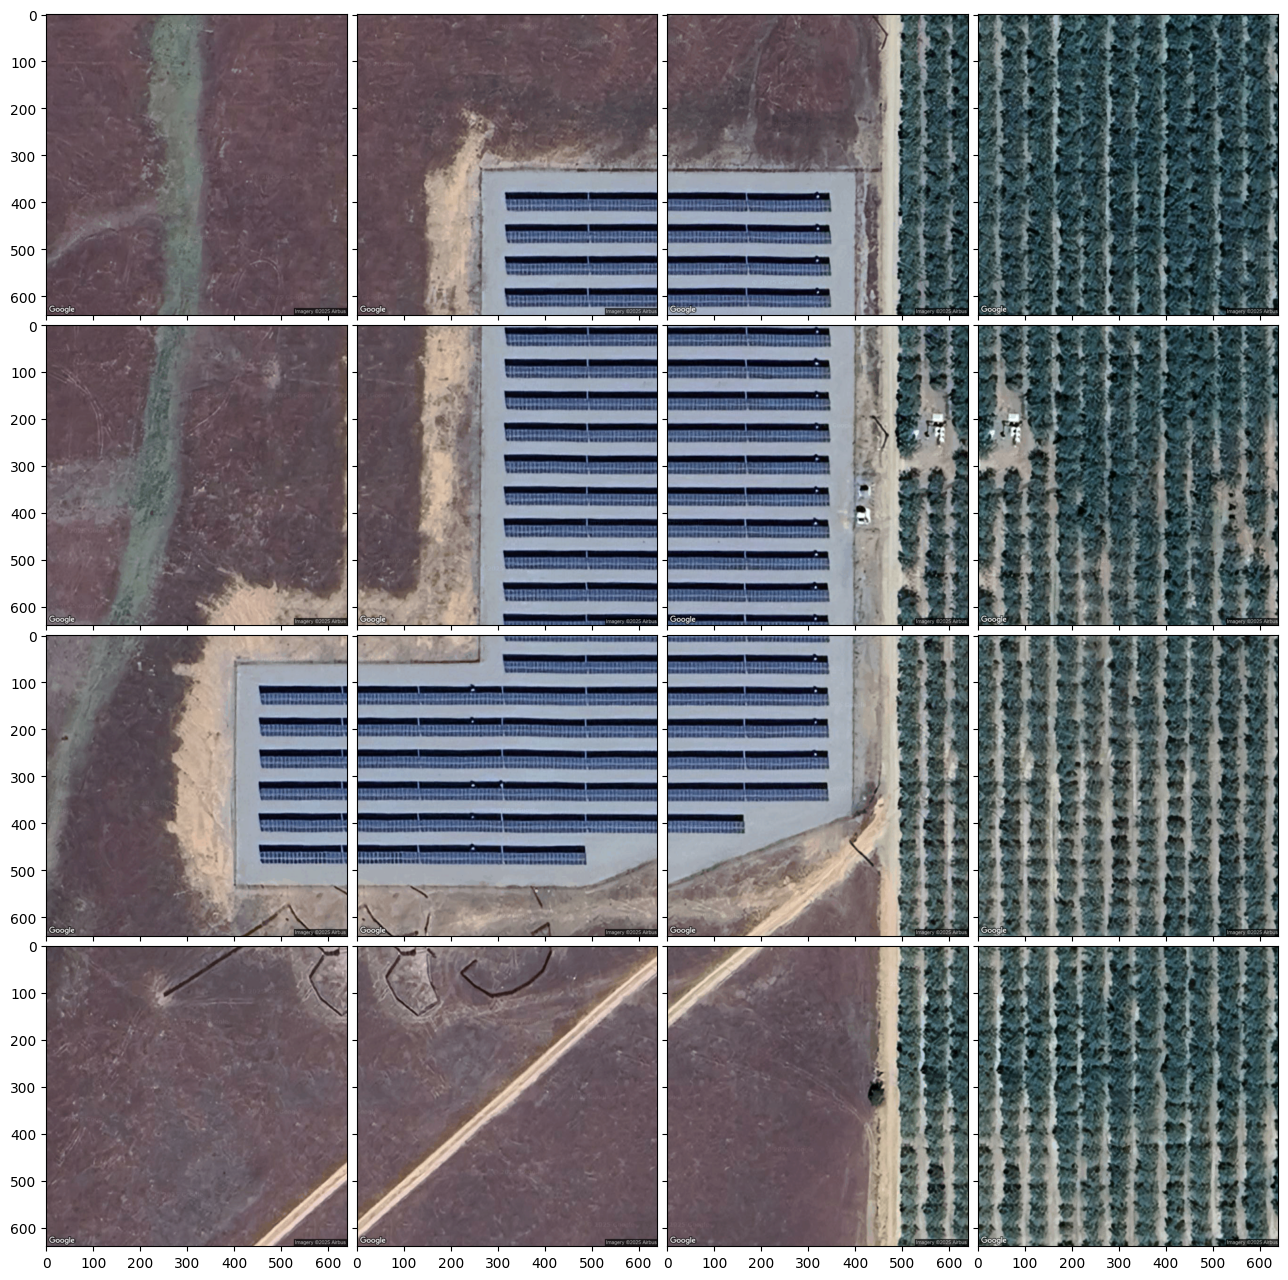

In [11]:
plot = utils.visualizeSatelliteImageryGrid(grid_info_list, file_save_folder)
plt.show()

Load in the automated geotagging CV algorithm. All images will be run through it to identify site equipment.

In [12]:
cfg = Config.fromfile("../../../panel_segmentation/models/automated_geotagging_config.py")
checkpoint_file = "../../../panel_segmentation/models/automated_geotagging_model.pth"
model = init_detector(cfg, device='cpu')
checkpoint = torch.load(checkpoint_file, map_location='cpu', weights_only=False)
model.load_state_dict(checkpoint['state_dict'])
visualizer = VISUALIZERS.build(model.cfg.visualizer)

# Run inference on the example images
inference_data_list = list()
results = list()
grid_files = glob.glob(os.path.join(file_save_folder, "*.png"))
for i, file in enumerate(grid_files):
    img = mmcv.imread(file, channel_order='rgb')
    new_result = inference_detector(model, img)
    new_result.file = file
    results.append(new_result)

c:\users\kperry\documents\source\repos\mmdetection\mmdet\apis\inference.py:70: UserWarning: checkpoint is None, use COCO classes by default.
  warnings.warn('checkpoint is None, use COCO classes by default.')
C:\Users\kperry\AppData\Roaming\Python\Python311\site-packages\mmengine\utils\manager.py:113: UserWarning: <class 'mmdet.visualization.local_visualizer.DetLocalVisualizer'> instance named of visualizer has been created, the method `get_instance` should not accept any other arguments
  warnings.warn(
c:\users\kperry\documents\source\repos\mmdetection\mmdet\models\layers\se_layer.py:158: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
c:\users\kperry\documents\source\repos\mmdetection\mmdet\models\backbones\csp_darknet.py:118: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cu

Convert all the masks to geoJSON's and merge them into a master geoJSON file.

In [13]:
inference_data_list = list()
for result in results:
    predictions = result._pred_instances
    masks = predictions.masks
    labels = predictions.labels
    scores = predictions.scores
    # Take all labels meeting a 0.3 threshold or greater
    idx_to_keep = np.argwhere(scores>=0.3).tolist()[0]
    file_name = os.path.basename(result.file)
    img_center_lat, img_center_lon = float(file_name.split("_")[0]), float(file_name.split("_")[-1].replace(".png", ""))
    image_x_pixels, image_y_pixels = new_result.img_shape
    # Convert all of the masks to latitude-longitude-based polygons
    for index in range(len(masks)):
            if index in idx_to_keep:
                segmentation_mask = masks[index].data.cpu().numpy()
                # Convert the mask to a polygon
                polygon_lat_lon_coords = utils.convertMaskToLatLonPolygon(segmentation_mask, 
                                                                    img_center_lat, 
                                                                    img_center_lon,
                                                                    image_x_pixels, 
                                                                    image_y_pixels,
                                                                    zoom_level=20)
                # Convert to a geoJSON
                shapely_poly = Polygon(polygon_lat_lon_coords)
                if not shapely.is_valid(shapely_poly):
                    shapely_poly =shapely.make_valid(shapely_poly)
                geojson_poly = geopandas.GeoSeries(shapely_poly).to_json()
                inference_data_list.append({"image": result.file,
                                            "poly": shapely_poly,
                                            "label": int(labels[index])})
inference_df = pd.DataFrame(inference_data_list)
inference_df[inference_df['label']==3].head(20)

,image,poly,label
0,../../../panel_segmentation/examples/automated...,POLYGON ((-122.13381358368964 38.9958884489001...,3


Fuse features of the same mask type.

In [14]:
labels = list(inference_df['label'].drop_duplicates())
merged_features = list()
for label in labels:
    inference_label_subset = inference_df[inference_df['label'] == label]
    polygons = list(inference_label_subset['poly'])
    print(label)
    # Run a union for the labels to fuse them all together
    unioned = unary_union(polygons)
    if unioned.geom_type == "Polygon":
        merged_features.append({
                "type": "Feature",
                "properties": {"class": label},
                "geometry": mapping(unioned)
            })
    else:
        for poly in unioned.geoms:
            merged_features.append({
                    "type": "Feature",
                    "properties": {"class": label},
                    "geometry": mapping(poly)
                })
geojson = {"type": "FeatureCollection", "features": merged_features}

3
2
0


Show the final mapped geoJSON data.

In [16]:
 m = folium.Map(location=[sys_latitude, sys_longitude],
                zoom_start=18,
                tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
                attr = 'Esri',
                name = 'Esri Satellite')

folium.GeoJson(
        geojson
    ).add_to(m)
m